In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from matplotlib.colors import ListedColormap
import random

%matplotlib inline

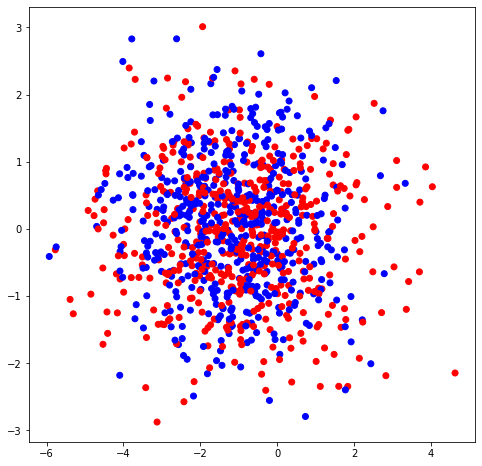

In [2]:

# data preparation
"""make_classification(n_samples=100, n_features=20, *, n_informative=2, n_redundant=2, n_repeated=0, 
n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, 
scale=1.0, shuffle=True, random_state=None)"""
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 15, 
                                                                          n_informative = 7, n_classes = 2, 
                                                                          n_redundant=0, n_clusters_per_class=1, 
                                                                          random_state=15, shuffle=True)
colors = ListedColormap(['red', 'blue'])
plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [3]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [5]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет критерия Энтропия

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_value, criterion = 'gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    if criterion == 'entropy':
        new_value = current_value - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    else:
        new_value = current_value - p * gini(left_labels) - (1 - p) * gini(right_labels)
    return new_value

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [10]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [11]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [12]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [13]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [14]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

## Урок 4. Алгоритм построения дерева решений
1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).
2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.
3. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.*

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [15]:
def find_best_split(data, labels, limit_leafs = 0, limit_features = -1, criterion = 'gini'):
    
    #  minimal leafs in node
    if limit_leafs:
        min_leaf = limit_leafs
    else:
        min_leaf = 5
    
    if criterion == 'entropy':
        current_value = entropy(labels)
    else:
        current_value = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    #  limit features
    if limit_features != -1:
        if limit_features < data.shape[1]:
            n_features = limit_features
        else:
            n_features = data.shape[1]
    else:
        n_features = data.shape[1]
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  ignore nodes with leafs number less than limit
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                #print(f'True length - {len(true_data)}/nFalse length - {len(false_data)}')
                continue
            
            current_quality = quality(true_labels, false_labels, current_value, criterion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [16]:
def build_tree(data, labels, limit_leafs = 0, limit_depth = -1, limit_features = 0, criterion = 'gini'):
    # tree depth control
    depth = limit_depth

    quality, t, index = find_best_split(data, labels, limit_leafs+1, limit_features, criterion)
    
    if depth:
        depth -= 1
    else:
        return Leaf(data, labels)

    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, limit_leafs, depth, limit_features, criterion)
    false_branch = build_tree(false_data, false_labels, limit_leafs, depth, limit_features, criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [17]:
# Построим дерево по обучающей выборке
min_leafs = 12
max_depth = 5
max_features = 9
my_tree = build_tree(train_data, train_labels, min_leafs, max_depth, max_features)

In [18]:
#print_tree(my_tree)
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
print(f'Точность на обучающей выборке - {train_accuracy}\nТочность на тестовой выборке - {test_accuracy}')


Точность на обучающей выборке - 84.57142857142857
Точность на тестовой выборке - 81.33333333333333


Text(0.5, 1.0, 'Test accuracy=81.33')

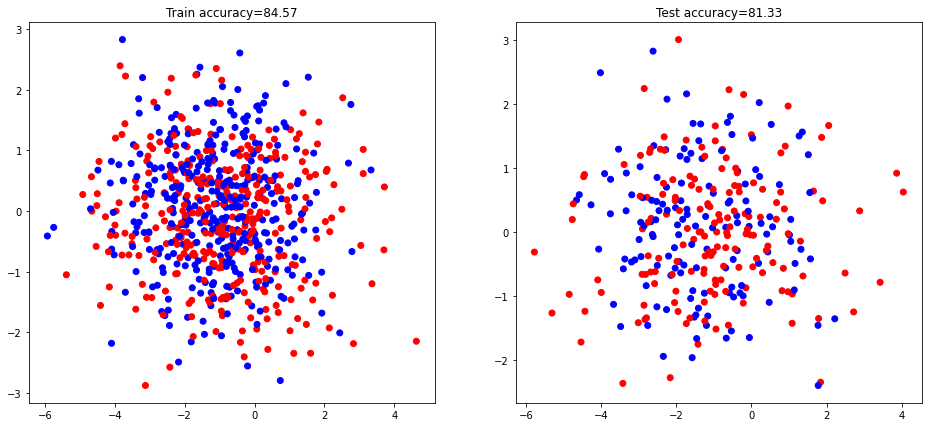

In [20]:
plt.figure(figsize = (16, 7))
light_colors = ListedColormap(['lightcoral', 'lightblue'])
# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
"""mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)"""
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
#plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### 2. Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

In [21]:
# Расчет критерия Энтропия

def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p * np.log2(p)
        
    return impurity

In [22]:
# Расчет качества

def quality(left_labels, right_labels, current_value, criterion = 'gini'):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    if criterion == 'entropy':
        new_value = current_value - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    else:
        new_value = current_value - p * gini(left_labels) - (1 - p) * gini(right_labels)
    return new_value

In [23]:
# Построим дерево по обучающей выборке с теми же параметрами что и для критерия Джини
current_criterion = 'entropy'
"""min_leafs = 7
max_depth = 5
max_features = 10"""
my_tree = build_tree(train_data, train_labels, min_leafs, max_depth, max_features, current_criterion)
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [24]:
# Точность на обучающей выборке
train_accuracy_en = accuracy_metric(train_labels, train_answers)
# Точность на тестовой выборке
test_accuracy_en = accuracy_metric(test_labels, answers)
print(f'Точность на обучающей выборке:\nДжини - {train_accuracy}\tЭнтропия - {train_accuracy_en}\nТочность на тестовой выборке:\nДжини - {test_accuracy}\tЭнтропия - {test_accuracy_en}')

Точность на обучающей выборке:
Джини - 84.57142857142857	Энтропия - 83.42857142857143
Точность на тестовой выборке:
Джини - 81.33333333333333	Энтропия - 81.66666666666667


Качество классификации при выбранных параметрах для энтропии незначительно лучше, так как при меньшем переобучении на тренировочных данных получается более высокая точность на тестовых. Но при увеличении переобучения на тренировочных данных и быстрее падает качество на тестовых даннхы при использовании энтропии в сравнении с Джини.